<div style="background:#0f172a; color:#f9fafb; padding:18px; border-radius:10px; border:1px solid #1e293b;">

<h1 style="margin-top:0; font-size:1.9em;">🧱 Base Pipeline – Text & Domain Models for Any Email Dataset</h1>

<p style="margin-bottom:0;">
This notebook trains the <strong>baseline (non-deep)</strong> models for a chosen email dataset.
By changing <code>DATASET_TAG</code>, we can reuse the same pipeline for:
</p>

<ul>
  <li>Balanced <strong>pre-2010</strong> authentic emails</li>
  <li>Balanced <strong>post-2010</strong> authentic emails</li>
  <li><strong>Synthetic</strong> LLM-generated emails</li>
  <li><strong>Combined</strong> pre-2010 + post-2010 authentic emails</li>
  <li><strong>Combined</strong> authentic + synthetic emails</li>
</ul>

<p>
For the selected dataset, this notebook will:
</p>

<ul>
  <li>Load the 3-class email data and reconstruct the text field.</li>
  <li>Build a TF-IDF + Logistic Regression baseline classifier.</li>
  <li>Extract RDAP/DNS + age features from sender domains.</li>
  <li>Train an AdaBoost domain-only classifier.</li>
  <li>Combine both models into a soft-voting ensemble.</li>
  <li>Save all trained models under a dataset-specific folder.</li>
</ul>

</div>

<div style="margin-top:10px; padding:12px; border-left:5px solid #3b82f6; background:#eff6ff;">
<strong>Step 0 – Environment & dataset selection</strong><br>
Install dependencies, mount Google Drive, set random seeds, define project paths, and choose the
<code>DATASET_TAG</code> that tells this pipeline which CSV to train on.
</div>


In [ ]:
!pip install dnspython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 26.4 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import torch

SEED = 67  # choose any number you want

random.seed(SEED)
np.random.seed(SEED)

# PyTorch CPU and GPU (if available)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensures determinism in certain CUDA operations
torch.use_deterministic_algorithms(True, warn_only=True)


In [ ]:
#Library List
from google.colab import drive
drive.mount("/content/drive")

import os
from pathlib import Path

import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


import requests
import dns.resolver
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm





Mounted at /content/drive


In [ ]:
# === Project root & derived paths ===
PROJECT_ROOT = "/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/"

# Main folders (adjust subfolder names if yours differ)
DATA_PATH   = os.path.join(PROJECT_ROOT, "Datasets/")            # all CSVs, splits, model dirs
FOLDER_PATH = os.path.join(PROJECT_ROOT, "Real Data/")  # change this name to match your actual folder

# 🔹 Choose which dataset this run is using (name WITHOUT .csv)
DATASET_TAG = "emails_before2010_balanced"

# All trained models for THIS dataset go here
MODEL_DIR = os.path.join(DATA_PATH, "Models", DATASET_TAG)
os.makedirs(MODEL_DIR, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("FOLDER_PATH:", FOLDER_PATH)
print("MODEL_DIR:", MODEL_DIR)


# === Load chosen 3-class email dataset ===
combined_path = Path(DATA_PATH) / f"{DATASET_TAG}.csv"
assert combined_path.exists(), f"{combined_path} not found. Check DATASET_TAG or run your data-prep notebook."
combined = pd.read_csv(combined_path)


Load Datasets + indices

In [ ]:
# sanity check: required columns
required_cols = ["subject", "body", "label_3class", "sender_domain", "date"]
missing = [c for c in required_cols if c not in combined.columns]
assert not missing, f"Missing columns in combined_emails_3class.csv: {missing}"

# Build text field exactly like original notebook: subject + body
combined["text"] = combined["subject"].fillna("") + " " + combined["body"].fillna("")
combined["date"] = pd.to_datetime(combined["date"], errors="coerce")
combined.head()


,sender,receiver,date,subject,body,label,urls,sender_emails,receiver_emails,sender_email,...,year,label_binary,receiver_email_primary,receiver_domains,label_name,subject_len,body_len,subject_body,body_only,text
0,"""Kyle, Co-Founder (Wealthy Affiliate)"" <kyle@w...",[UNKNOWN],2023-03-17,Welcome to Wealthy Affiliate! Your Exciting Jo...,Welcome to Wealthy Affiliate! Your Exciting Jo...,Spam,[],['kyle@wealthyaffiliate.com'],[],kyle@wealthyaffiliate.com,...,2023.0,0,NaN,[],spam,65,2418,Welcome to Wealthy Affiliate! Your Exciting Jo...,Welcome to Wealthy Affiliate! Your Exciting Jo...,Welcome to Wealthy Affiliate! Your Exciting Jo...
1,Genius <Genius@geniusmessages.com>,[UNKNOWN],2023-02-23,Genius sent you a message on Genius,Genius sent you a message on Genius: Hi HoneyC...,Spam,[],['Genius@geniusmessages.com'],[],genius@geniusmessages.com,...,2023.0,0,NaN,[],spam,35,1227,Genius sent you a message on Genius Genius sen...,Genius sent you a message on Genius: Hi HoneyC...,Genius sent you a message on Genius Genius sen...
2,﻿AEONクレジットサービス <Aeon.egoodsports@dedn.net>,[UNKNOWN],2025-09-18,イオンカード：ご利用地域取引の認証更新手続きのご通知,イオンカード：ご利用地域取引の認証更新手続きのご通知 ご利用地域取引の認証更新手続きのご通知...,Spam,[],['Aeon.egoodsports@dedn.net'],[],aeon.egoodsports@dedn.net,...,2025.0,0,NaN,[],spam,26,756,イオンカード：ご利用地域取引の認証更新手続きのご通知 イオンカード：ご利用地域取引の認証更新...,イオンカード：ご利用地域取引の認証更新手続きのご通知 ご利用地域取引の認証更新手続きのご通知...,イオンカード：ご利用地域取引の認証更新手続きのご通知 イオンカード：ご利用地域取引の認証更新...
3,ryan kirchner<rkirchner22@yahoo.com>\n,[UNKNOWN],2025-05-17,AI Compute/Research Opportunity,Anonymous - Would the University of Oslo (and ...,Spam,[],['rkirchner22@yahoo.com'],[],rkirchner22@yahoo.com,...,2025.0,0,NaN,[],spam,31,680,AI Compute/Research Opportunity Anonymous - Wo...,Anonymous - Would the University of Oslo (and ...,AI Compute/Research Opportunity Anonymous - Wo...
4,Story Alerts | The Star <storyalerts@thestar.ca>,[UNKNOWN],2023-08-18,There’s a new Matt Elliott column online now,New from Matt Elliott Just published: Why mayo...,Spam,[],['storyalerts@thestar.ca'],[],storyalerts@thestar.ca,...,2023.0,0,NaN,[],spam,44,1182,There’s a new Matt Elliott column online now N...,New from Matt Elliott Just published: Why mayo...,There’s a new Matt Elliott column online now N...


<h2 style="border-bottom:3px solid #6366f1; padding-bottom:4px;">
🧮 Step 2 – Build a stable train/test split for this dataset
</h2>

<p>
To keep evaluations consistent across runs and notebooks, we use <strong>dataset-specific index files</strong>:
</p>

<ul>
  <li>If <code>train_idx_&lt;DATASET_TAG&gt;.npy</code> and <code>test_idx_&lt;DATASET_TAG&gt;.npy</code> exist, we reuse them.</li>
  <li>If the dataset size has changed or the files are missing, we regenerate a stratified 80/20 split.</li>
  <li>The same indices are reused for text models and domain models later.</li>
</ul>

<p>
Finally, we build <code>train_df</code> and <code>test_df</code> and extract:
<code>X_train_text</code>, <code>X_test_text</code>, <code>y_train</code>, and <code>y_test</code> for the selected dataset.
</p>


In [ ]:
# === Train / Test split indices (dataset-specific) ===

# IMPORTANT: Do NOT change DATASET_TAG here.
# It should already be set above to: "emails_after2010_balanced"

train_idx_path = Path(DATA_PATH) / f"train_idx_{DATASET_TAG}.npy"
test_idx_path  = Path(DATA_PATH) / f"test_idx_{DATASET_TAG}.npy"

labels = combined["label_3class"].values
indices = np.arange(len(combined))


def make_split():
    """Create a fresh, seed-controlled train/test split and save to disk."""
    t_idx, v_idx, _, _ = train_test_split(
        indices,
        labels,
        test_size=0.20,
        stratify=labels,
        random_state=SEED,
    )
    np.save(train_idx_path, t_idx)
    np.save(test_idx_path, v_idx)
    print(f"Created and saved new train/test indices for {DATASET_TAG}.")
    return t_idx, v_idx


if train_idx_path.exists() and test_idx_path.exists():
    train_idx = np.load(train_idx_path)
    test_idx = np.load(test_idx_path)
    print(f"Loaded existing train/test indices for {DATASET_TAG}.")

    # 🔍 Check that saved indices are valid for *current* dataset size
    max_idx = max(train_idx.max(), test_idx.max())
    if max_idx >= len(combined):
        print(
            f"Saved indices are incompatible with current dataset "
            f"(max_idx={max_idx}, len={len(combined)}). Regenerating..."
        )
        train_idx, test_idx = make_split()
else:
    train_idx, test_idx = make_split()

print("Train size:", len(train_idx), "Test size:", len(test_idx))

# Now safely index into the dataframe
train_df = combined.iloc[train_idx].reset_index(drop=True)
test_df  = combined.iloc[test_idx].reset_index(drop=True)
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)


Loaded existing train/test indices for emails_after2010_balanced.
Saved indices are incompatible with current dataset (max_idx=2001, len=2000). Regenerating...
Created and saved new train/test indices for emails_after2010_balanced.
Train size: 1600 Test size: 400
train_df shape: (1600, 24)
test_df shape: (400, 24)


In [ ]:
# === Build train/test DataFrames from indices ===
train_df = combined.iloc[train_idx].reset_index(drop=True)
test_df  = combined.iloc[test_idx].reset_index(drop=True)

X_train_text = train_df["text"]
y_train = train_df["label_3class"]

X_test_text = test_df["text"]
y_test = test_df["label_3class"]

y_train.value_counts(), y_test.value_counts()


(label_3class
 2    798
 1    746
 0     56
 Name: count, dtype: int64,
 label_3class
 2    200
 1    186
 0     14
 Name: count, dtype: int64)

<h2 style="border-bottom:3px solid #f97316; padding-bottom:4px;">
📖 Step 3 – Text-only baseline: TF-IDF + Logistic Regression
</h2>

<p>
We now train a <strong>bag-of-ngrams baseline</strong> on the email text:
</p>

<ul>
  <li>Convert <code>subject + body</code> into TF-IDF features with unigrams and bigrams.</li>
  <li>Train a multinomial <code>LogisticRegression</code> model on the 3-class labels.</li>
  <li>Evaluate precision, recall, and F1 on the clean test split and visualize the confusion matrix.</li>
</ul>

<p>
This provides a strong, interpretable baseline that can be compared across
<em>any dataset selected by <code>DATASET_TAG</code></em>.
</p>


<h2 style="border-bottom:3px solid #22c55e; padding-bottom:4px;">
💾 Step 4 – Persist TF-IDF and Logistic Regression models
</h2>

<p>
We save both the <strong>TF-IDF vectorizer</strong> and the <strong>Logistic Regression classifier</strong> to
a dataset-specific folder:
</p>

<ul>
  <li><code>tfidf_vectorizer_&lt;DATASET_TAG&gt;.joblib</code></li>
  <li><code>logreg_tfidf_3class_&lt;DATASET_TAG&gt;.joblib</code></li>
</ul>

<p>
Later notebooks (e.g., evaluation, TextFooler attacks) can reload these artifacts and use the
<strong>exact same training configuration</strong> for any of the five dataset variants.
</p>


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (TF-IDF) – clean test set
              precision    recall  f1-score   support

           0       0.75      0.21      0.33        14
           1       0.94      0.95      0.94       186
           2       0.93      0.96      0.95       200

    accuracy                           0.93       400
   macro avg       0.87      0.71      0.74       400
weighted avg       0.93      0.93      0.92       400



['/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/logreg_tfidf_3class_emails_after2010_balanced.joblib']

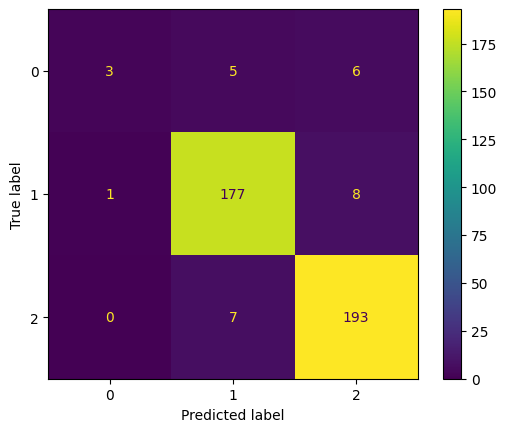

In [ ]:
# === TF-IDF Vectorizer ===
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english",
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_test_tfidf.shape

# === Multinomial Logistic Regression ===
lr = LogisticRegression(
    max_iter=5000,
    n_jobs=-1,
    multi_class="multinomial",
    random_state=SEED,
)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regression (TF-IDF) – clean test set")
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)

# === Save TF-IDF + LR models ===
tfidf_filename = f"tfidf_vectorizer_{DATASET_TAG}.joblib"
logreg_filename = f"logreg_tfidf_3class_{DATASET_TAG}.joblib"

# THIS must save the vectorizer:
joblib.dump(tfidf, os.path.join(MODEL_DIR, tfidf_filename))

# THIS must save the logistic regression model:
joblib.dump(lr, os.path.join(MODEL_DIR, logreg_filename))



<h2 style="border-bottom:3px solid #8b5cf6; padding-bottom:4px;">
🌐 Step 5 – Define RDAP/DNS utilities for sender-domain features
</h2>

<p>
To capture <strong>infrastructure-level signals</strong>, we enrich each sender domain with information from:
</p>

<ul>
  <li><strong>RDAP</strong> – registration data, status flags, and creation dates.</li>
  <li><strong>DNS</strong> – presence and counts of A, MX, NS, and TXT records.</li>
</ul>

<p>
These helper functions:
</p>

<ul>
  <li>Cache responses to avoid repeating network calls.</li>
  <li>Handle timeouts and failures gracefully.</li>
  <li>Convert RDAP/DNS responses into a consistent feature dictionary for a single domain.</li>
</ul>

<p>
The same logic applies regardless of whether the emails are pre-2010, post-2010, synthetic,
or combined.
</p>


In [ ]:
# === RDAP / DNS helper functions ===

# global caches
rdap_cache = {}
dns_cache = {}
dns_resolver = dns.resolver.Resolver()

def rdap_lookup_fast(domain: str):
    """RDAP lookup with caching + short timeout."""
    if domain in rdap_cache:
        return rdap_cache[domain]
    url = f"https://rdap.org/domain/{domain}"
    try:
        resp = requests.get(url, timeout=3)
        resp.raise_for_status()
        data = resp.json()
    except requests.RequestException:
        data = None
    rdap_cache[domain] = data
    return data

def dns_lookup_fast(domain: str):
    """DNS lookup with caching + short timeout."""
    if domain in dns_cache:
        return dns_cache[domain]
    records = {}
    for rtype in ["A", "MX", "NS", "TXT"]:
        try:
            answers = dns_resolver.resolve(domain, rtype, lifetime=3)
            records[rtype] = [ans.to_text() for ans in answers]
        except Exception:
            records[rtype] = []
    dns_cache[domain] = records
    return records

def extract_domain_features(domain: str):
    """
    Use rdap_lookup_fast + dns_lookup_fast to build numeric features for one sender_domain.
    Includes RDAP existence, status flags, DNS record counts, and domain age features.
    """
    feats = {
        "sender_domain": domain,
        "rdap_exists": 0,
        "rdap_has_active_status": 0,
        "rdap_has_hold_status": 0,
        "dns_a_count": 0,
        "dns_mx_count": 0,
        "dns_ns_count": 0,
        "dns_txt_count": 0,
        "has_mx": 0,
        "domain_creation_date": pd.NaT,
    }

    if not isinstance(domain, str) or not domain:
        return feats

    # --- RDAP ---
    rdap_data = rdap_lookup_fast(domain)
    if rdap_data is not None:
        feats["rdap_exists"] = 1
        status_list = rdap_data.get("status", []) or []
        status_lower = [s.lower() for s in status_list]
        if any("active" in s for s in status_lower):
            feats["rdap_has_active_status"] = 1
        if any("hold" in s for s in status_lower):
            feats["rdap_has_hold_status"] = 1

        # earliest registration/creation date
        events = rdap_data.get("events", []) or []
        creation_dt = None
        for ev in events:
            action = (ev.get("eventAction") or "").lower()
            if ("registration" in action) or ("creation" in action):
                dt = pd.to_datetime(ev.get("eventDate"), errors="coerce", utc=True)
                if pd.notna(dt) and (creation_dt is None or dt < creation_dt):
                    creation_dt = dt
        if creation_dt is not None:
            feats["domain_creation_date"] = creation_dt.tz_convert(None)

    # --- DNS ---
    dns_data = dns_lookup_fast(domain)
    a_records = dns_data.get("A", [])
    mx_records = dns_data.get("MX", [])
    ns_records = dns_data.get("NS", [])
    txt_records = dns_data.get("TXT", [])

    feats["dns_a_count"] = len(a_records)
    feats["dns_mx_count"] = len(mx_records)
    feats["dns_ns_count"] = len(ns_records)
    feats["dns_txt_count"] = len(txt_records)
    feats["has_mx"] = int(len(mx_records) > 0)

    return feats


<h2 style="border-bottom:3px solid #0ea5e9; padding-bottom:4px;">
🛰️ Step 6 – Run RDAP/DNS lookups for all sender domains
</h2>

<p>
For the current dataset, we:
</p>

<ul>
  <li>Collect all unique <code>sender_domain</code> values.</li>
  <li>Use a thread pool to parallelize RDAP/DNS lookups with progress tracking.</li>
  <li>Aggregate the results into <code>domain_features_df</code> (one row per domain).</li>
  <li>Optionally cache these features as <code>sender_domain_rdapdns_features_&lt;DATASET_TAG&gt;.csv</code>.</li>
</ul>

<p>
This avoids re-querying external services every time we rerun the notebook,
and works for any dataset variant that includes <code>sender_domain</code>.
</p>


In [ ]:
# === Extract RDAP/DNS features for all unique sender domains ===
unique_domains = combined["sender_domain"].dropna().unique()
len(unique_domains)

rows = []

def extract_with_domain(dom):
    return extract_domain_features(dom)

pbar = tqdm(total=len(unique_domains), desc="RDAP/DNS lookups", ncols=100)
with ThreadPoolExecutor(max_workers=15) as executor:
    futures = {executor.submit(extract_with_domain, dom): dom for dom in unique_domains}
    for f in as_completed(futures):
        try:
            rows.append(f.result())
        except Exception:
            pass
        pbar.update(1)
pbar.close()

domain_features_df = pd.DataFrame(rows)
domain_features_df.head()


# Optional: cache domain features to disk for reuse
domain_feat_path = Path(DATA_PATH) / f"sender_domain_rdapdns_features_{DATASET_TAG}.csv"
domain_features_df.to_csv(domain_feat_path, index=False)
domain_feat_path


RDAP/DNS lookups:   0%|                                                    | 0/1083 [00:00<?, ?it/s]

PosixPath('/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/sender_domain_rdapdns_features_emails_after2010_balanced.csv')

<h2 style="border-bottom:3px solid #facc15; padding-bottom:4px;">
🏗️ Step 7 – Attach domain features to emails and construct X<sub>domain</sub>
</h2>

<p>
We join the per-domain RDAP/DNS features back onto each individual email, then derive:
</p>

<ul>
  <li><strong>Domain age at send time</strong> (days).</li>
  <li>Binary flags for <em>“new within 30 days”</em> and <em>“new within 90 days”</em>.</li>
</ul>

<p>
After filling missing values, we extract a clean numeric feature matrix:
<code>X_domain_all</code> with columns:
</p>

<ul>
  <li><code>rdap_exists</code>, <code>rdap_has_active_status</code>, <code>rdap_has_hold_status</code></li>
  <li><code>dns_a_count</code>, <code>dns_mx_count</code>, <code>dns_ns_count</code>, <code>dns_txt_count</code>, <code>has_mx</code></li>
  <li><code>domain_age_days_at_email</code>, <code>domain_is_new_30d</code>, <code>domain_is_new_90d</code></li>
</ul>

<p>
This matrix is aligned with the same rows as the original dataset, so we can reuse
the existing train/test indices.
</p>


In [ ]:
# === Merge RDAP/DNS features into per-email DataFrame ===
df = combined.copy()
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df = df.merge(domain_features_df, on="sender_domain", how="left")

# domain age at email time
df["domain_creation_date"] = pd.to_datetime(df["domain_creation_date"], errors="coerce")
df["domain_age_days_at_email"] = (df["date"] - df["domain_creation_date"]).dt.days

df["domain_is_new_30d"] = (
    (df["domain_age_days_at_email"] >= 0)
    & (df["domain_age_days_at_email"] <= 30)
).astype(int)

df["domain_is_new_90d"] = (
    (df["domain_age_days_at_email"] >= 0)
    & (df["domain_age_days_at_email"] <= 90)
).astype(int)

domain_cols = [
    "rdap_exists",
    "rdap_has_active_status",
    "rdap_has_hold_status",
    "dns_a_count",
    "dns_mx_count",
    "dns_ns_count",
    "dns_txt_count",
    "has_mx",
    "domain_age_days_at_email",
    "domain_is_new_30d",
    "domain_is_new_90d",
]

# ensure columns exist + fill NaNs
for col in domain_cols:
    if col not in df.columns:
        df[col] = 0
    else:
        df[col] = df[col].fillna(0)

X_domain_all = df[domain_cols].astype(float)
X_domain_all.head()


# === Build train/test RDAP/DNS matrices using shared indices ===
X_train_domain = X_domain_all.iloc[train_idx]
X_test_domain  = X_domain_all.iloc[test_idx]

# y_train / y_test already defined above from the same indices
X_train_domain.shape, X_test_domain.shape


((1600, 11), (400, 11))

<h2 style="border-bottom:3px solid #fb7185; padding-bottom:4px;">
🌱 Step 8 – Domain-only classifier: AdaBoost on RDAP/DNS features
</h2>

<p>
Now we train a <strong>domain-only classifier</strong> that ignores the email text and relies solely on
RDAP/DNS + age features:
</p>

<ul>
  <li>Split <code>X_domain_all</code> into <code>X_train_domain</code> / <code>X_test_domain</code> using the same indices as text models.</li>
  <li>Train an <code>AdaBoostClassifier</code> on the 3-class labels.</li>
  <li>Evaluate performance and show its confusion matrix.</li>
</ul>

<p>
This model captures structural patterns like <em>“brand-new domain with no MX records”</em>, which may
flag phishing even if the email text looks benign.
We then save the trained AdaBoost model under the current <code>DATASET_TAG</code>.
</p>


AdaBoost – RDAP/DNS only
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.67      0.65      0.66       186
           2       0.66      0.72      0.69       200

    accuracy                           0.67       400
   macro avg       0.44      0.46      0.45       400
weighted avg       0.64      0.67      0.65       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models/emails_after2010_balanced/adaboost_rdapdns_3class_post2010.joblib']

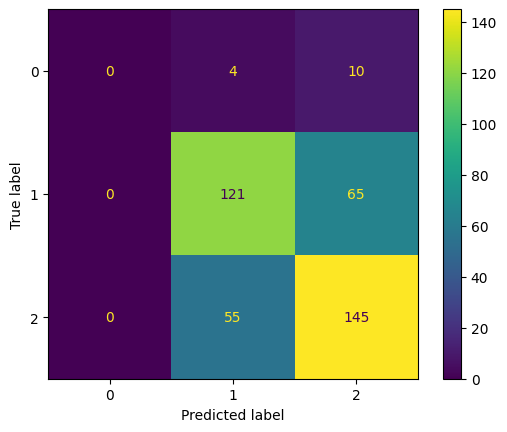

In [ ]:
# === AdaBoost – RDAP/DNS-only classifier ===
ada_domain = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.5,
    random_state=SEED,
)

ada_domain.fit(X_train_domain, y_train)
y_pred_ada = ada_domain.predict(X_test_domain)

print("AdaBoost – RDAP/DNS only")
print(classification_report(y_test, y_pred_ada))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ada)


# === Save AdaBoost RDAP/DNS model ===
joblib.dump(ada_domain, os.path.join(MODEL_DIR, "adaboost_rdapdns_3class_post2010.joblib"))


<h2 style="border-bottom:3px solid #64748b; padding-bottom:4px;">
🧷 Step 9 – Soft-voting ensemble of text and domain signals
</h2>

<p>
Finally, we combine the strengths of both base models into a <strong>soft-voting ensemble</strong>:
</p>

<ul>
  <li>Get <code>predict_proba</code> from the TF-IDF + LR text model and the RDAP/DNS AdaBoost model.</li>
  <li>Align class probabilities to a shared <code>classes_all = [0, 1, 2]</code> layout.</li>
  <li>Average the probabilities and take <code>argmax</code> as the ensemble prediction.</li>
</ul>

<p>
This ensemble can capture:
</p>

<ul>
  <li>Content-based cues from the email text.</li>
  <li>Infrastructure-based cues from the sender domain.</li>
</ul>

<p>
Because everything is keyed off <code>DATASET_TAG</code>, the same ensemble procedure works for:
pre-2010, post-2010, synthetic, combined authentic, and combined all datasets.
</p>


=== Base Ensemble (TF-IDF + LR  +  AdaBoost RDAP/DNS) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.94      0.96      0.95       186
           2       0.93      0.97      0.95       200

    accuracy                           0.93       400
   macro avg       0.62      0.64      0.63       400
weighted avg       0.90      0.93      0.92       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


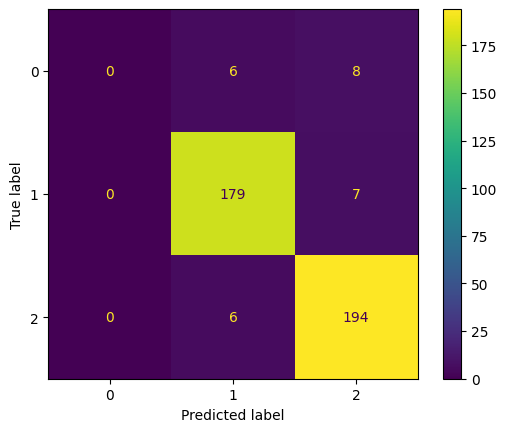

In [ ]:

# We'll build a soft-voting ensemble:
#   - get predicted probabilities from each model
#   - align them on the same class order
#   - average the probabilities
#   - take argmax as ensemble prediction

# all classes present in the problem
classes_all = np.array(sorted(np.unique(y_train)))  # e.g. [0, 1, 2]

def proba_aligned(clf, X, classes_all):
    """
    Return predict_proba for X with columns aligned to classes_all.
    This is safer than assuming clf.classes_ is already sorted the same way.
    """
    proba = clf.predict_proba(X)
    out = np.zeros((X.shape[0], len(classes_all)))
    for i, c in enumerate(clf.classes_):
        j = np.where(classes_all == c)[0][0]
        out[:, j] = proba[:, i]
    return out

# Probabilities from each base model
proba_lr_test  = proba_aligned(lr,         X_test_tfidf,  classes_all)
proba_ada_test = proba_aligned(ada_domain, X_test_domain, classes_all)

# Soft-voting: simple average (you can weight them later if you want)
proba_ens_test = (proba_lr_test + proba_ada_test) / 2.0

# Ensemble hard predictions
y_pred_base_ens = classes_all[np.argmax(proba_ens_test, axis=1)]

# Metrics
print("=== Base Ensemble (TF-IDF + LR  +  AdaBoost RDAP/DNS) ===")
print(classification_report(y_test, y_pred_base_ens))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base_ens)


In [ ]:
np.save(os.path.join(DATA_PATH, f"y_test_base_{DATASET_TAG}.npy"),         y_test)
np.save(os.path.join(DATA_PATH, f"y_pred_lr_base_{DATASET_TAG}.npy"),      y_pred_lr)
np.save(os.path.join(DATA_PATH, f"y_pred_ada_base_{DATASET_TAG}.npy"),     y_pred_ada)
np.save(os.path.join(DATA_PATH, f"y_pred_ens_base_{DATASET_TAG}.npy"),     y_pred_base_ens)


